# Onthefuze data test

In [1]:
import library
import requests
import pandas as pd
import re
import numpy as np
from geopy.geocoders import Nominatim
import pycountry
import phonenumbers
import matplotlib.pyplot as plt

## contact_collection
The contact_collection function is used to extract contact information from the API key provided in the data test. Conditional statements are added to facilitate the extraction of this information. This code is designed for reusability in other data frames, as the inputs will be the API key, the endpoint URL, and a dictionary specifying the structure where we assign the properties we want to extract from the HubSpot account.

In [2]:
def contact_collection(api_key, url, request_data):
    """
    Collects contact data from a paginated API endpoint.

    Args:
    - api_key (str): The API key for authentication.
    - url (str): The URL of the API endpoint.
    - request_data (dict): The data to be included in the API request.

    Returns:
    - pd.DataFrame: A pandas DataFrame containing the collected contact data.
    """
    
    # Set up headers for the API request
    headers = {
        'accept': "application/json",
        'content-type': "application/json",
        'authorization': "Bearer {}".format(api_key)
    }

    # Initialize the 'after' value
    after_value = 0
    
    # List to store DataFrames
    data_frames_list = []

    # Infinite loop to fetch paginated data
    while True:
        # Update the 'after' value in the request data
        request_data["after"] = str(after_value)

        # Make a POST request to the API
        response = requests.post(url, headers=headers, json=request_data)
        json_response = response.json()

        # Extract 'results' from the JSON response
        results = json_response['results']

        # Convert results to a DataFrame
        data_frame = pd.json_normalize(results)

        # Add the DataFrame to the list
        data_frames_list.append(data_frame)

        # Check if there are more pages in the response
        if 'paging' in json_response:
            paging = json_response['paging']
            next_page = paging.get('next')

            # Update 'after' for the next page if available
            if next_page:
                after_value = next_page.get('after')
                print("Value of 'after' for the next page:", after_value)
            else:
                print("No more results available.")
                break
        else:
            print("The 'paging' property was not found in the response.")
            break

    # Concatenate all DataFrames into a final DataFrame
    final_data_frame = pd.concat(data_frames_list, ignore_index=True)
    
    return final_data_frame

In [2]:
api_key = "pat-na1-3c7b0af9-bb66-40e7-a256-ce4c5eb27e81"
url = 'https://api.hubapi.com/crm/v3/objects/contacts/search'

data = {
    "filterGroups": [
        {
            "filters": [
                {
                    "propertyName": "allowed_to_collect",
                    "operator": "EQ",
                    "value": "true"
                }
            ]
        }
    ],
    "properties": [
        "firstname",
        "lastname",
        "raw_email",
        "country",
        "phone",
        "technical_test___create_date",
        "industry",
        "address",
        "hs_object_id"
    ],
    "limit": 100
}

In [ ]:
df = contact_collection(api_key, url, data)

We make a copy of the extracted dataframe for the purpose of working with it without altering the original and having to extract the information again.

In [4]:
df_copy=df.copy()

## found_email

The found_email function will be used to extract emails from a text. This is achieved by utilizing a regular expression that enables the search for a character sequence with an email-like structure.

In [5]:
def found_email(email):
    """
    Finds and extracts email addresses from the given email.

    Args:
    - email (str): The input email to search for email addresses.

    Returns:
    - str or np.nan: The found email address or np.nan if none is found.
    """
    # Check if the input email is null
    if pd.isnull(email):
        return np.nan
    
    # Define the email pattern using a regular expression
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}\b'
    
    # Search for the email pattern in the email
    match = re.search(email_pattern, email)
    
    # Check if a match is found
    if match:
        return match.group()  # Return the found email address
    else:
        return np.nan  # Return np.nan if no email address is found


In [6]:
df_copy['fix_email']=df_copy['properties.raw_email'].apply(found_email)

## country_recognition
The country_recognition function was designed to optimize the usage of the Geopy library. This optimization is necessary because applying the Geopy library directly to a dataframe can be time-consuming. The approach involves extracting unique country values, storing them in a temporary dataframe, and then applying the Geopy library only to those unique values. Subsequently, a function is used to replace those values in our main dataframe. This approach allows us to obtain information about countries other than Ireland and England.

Notes: 
The Geopy library recognizes the record for England as the United Kingdom. Therefore, the adjustment of this data is done at the end of the test, as the value "United Kingdom" will be used in our fix_phone_numbers function.

In [7]:

def country_recognition(dataframe, column_name):
    """
    Recognizes countries based on city names in a DataFrame.

    Args:
    - dataframe (pd.DataFrame): The input DataFrame containing city names.
    - column_name (str): The name of the column containing city names.

    Returns:
    - pd.DataFrame: A DataFrame with unique city values and their recognized countries.
    """
    # Get unique values and filter out NaN
    unique_values = dataframe[column_name].unique()
    unique_values = [value for value in unique_values if pd.notna(value)]

    # Create a DataFrame with unique values
    df_unique_values = pd.DataFrame({'unique_values': unique_values})

    # Get the country for each city using geocoding
    geolocator = Nominatim(user_agent="my_geocoder")
    df_unique_values['country'] = df_unique_values['unique_values'].apply(
        lambda city: (lambda loc: loc.address.split(",")[-1].strip() if loc else None)(geolocator.geocode(str(city)))
    )

    # Replace specific values in the 'country' column
    df_unique_values['country'] = df_unique_values['country'].replace(
        {'Éire / Ireland': 'Ireland'}
    )

    # Create the 'city' column based on a condition
    df_unique_values['city'] = np.where(
        df_unique_values['country'] == df_unique_values['unique_values'],
        "",
        df_unique_values['unique_values']
    )

    # Set 'city' to an empty string where 'country' is 'England'
    df_unique_values.loc[df_unique_values['city'] == 'England', 'city'] = ""

    # Update the original DataFrame with recognized countries and cities
    dataframe['country'] = dataframe[column_name].replace(
        dict(zip(df_unique_values['unique_values'], df_unique_values['country']))
    )
    dataframe['city'] = dataframe[column_name].replace(
        dict(zip(df_unique_values['unique_values'], df_unique_values['city']))
    )

    # Create the 'country_tuple' column
    #dataframe['country_tuple'] = dataframe.apply(
        #lambda x: tuple([x["country"], x["city"]]) if pd.notna(x["country"]) else np.nan,
        #axis=1
    #)

    dataframe['country_tuple'] = dataframe.apply(
    lambda x: tuple(['England' if x["country"] == 'United Kingdom' else x["country"], x["city"]]) if pd.notna(x["country"]) else np.nan,
    axis=1
)

    return df_unique_values



In [8]:
country_recognition(df_copy,"properties.country")

,unique_values,country,city
0,Waterford,Ireland,Waterford
1,Ireland,Ireland,
2,Dublin,Ireland,Dublin
3,London,United Kingdom,London
4,Limerick,Ireland,Limerick
5,Winchester,United Kingdom,Winchester
6,Milton Keynes,United Kingdom,Milton Keynes
7,Oxford,United Kingdom,Oxford
8,Cork,Ireland,Cork
9,Plymouth,United Kingdom,Plymouth


## fix_phone_numbers

The fix_phone_numbers function uses two libraries to find the country code. These libraries are pycountry, which helps us extract the simplified country name (e.g., "Colombia = CO"), and the phonenumbers library. The latter takes the simplified country name as input and returns the country code as the result.

Note: The pycountry library recognizes the value for the United Kingdom, which is why that value is temporarily used in the dataframe.

In [9]:
def fix_phone_numbers(phone, country_name):
    """
    Fixes phone numbers by adding country codes and formatting.

    Args:
    - phone (str): The phone number to be fixed.
    - country_name (str): The name of the country associated with the phone number.

    Returns:
    - str or np.nan: The formatted phone number or np.nan if input is invalid.
    """
    # Check if input values are valid
    if phone is None or country_name is None or phone == "":
        return np.nan
    
    try:
        # Get the country code based on the country name using pycountry
        country = pycountry.countries.get(name=country_name)
        
        if country:
            # Get the alpha-2 country code and phone code for the region
            country_code = country.alpha_2
            phone_code = phonenumbers.country_code_for_region(country_code)
        else:
            return np.nan
    except LookupError:
        return np.nan

    # Remove non-digit characters and leading '0', then format the number
    digits = re.sub(r'\D', '', str(phone)).lstrip('0')
    formatted_number = f'(+{phone_code}) {digits[:4]} {digits[4:]}'

    return formatted_number

In [10]:
df_copy['fix_phone'] = df_copy.apply(lambda row: fix_phone_numbers(row['properties.phone'], row['country']), axis=1)

## duplicate_management

For the duplicate_management function, we use the groupby function from pandas to perform a merge between duplicate records. In this function, the merge is performed twice. Initially, it is used to identify duplicates based on emails. Subsequently, we perform another identification using both the full name and the phone number.

Notes:
It is essential to note that the identification of duplicates based on first name and last name is only performed when they share the same email. This is because in the dataframe, instances were observed where records had the same name but different emails. Therefore, priority is given to the email as a mandatory property in HubSpot.

Example:

Full name     Email

Zara Rodwell  zara_rodwell1398442854@nickia.com

Zara Rodwell  zara_rodwell1270511699@zorer.org

The code identifies these records as different, respecting the email as the contact identifier.




In [11]:

def duplicate_management(input_dataframe):
    """
    Process the input DataFrame by combining and aggregating data.

    Args:
    - input_dataframe (pd.DataFrame): The input DataFrame to be processed.

    Returns:
    - pd.DataFrame: The processed DataFrame.
    """

    # Create a copy of the input DataFrame
    df_copy = input_dataframe.copy()

    # Create a 'Full name' column by concatenating 'firstname' and 'lastname'
    df_copy['Full name'] = df_copy['properties.firstname'] + ' ' + df_copy['properties.lastname']

    # Filter rows where 'fix_email' is NaN
    df_filtrado = df_copy[df_copy['fix_email'].isna()]

    # Sort the DataFrame by 'fix_email' and 'technical_test___create_date'
    df_copy.sort_values(["fix_email", "properties.technical_test___create_date"], ascending=[True, False], inplace=True)

    # Group by 'fix_email' and aggregate data
    processed_data1 = df_copy.groupby('fix_email').agg({
        'id': 'first',
        'createdAt': 'first',
        'updatedAt': 'first',
        'archived': 'first',
        'properties.address': 'first',
        'properties.country': 'first',
        'properties.createdate': 'first',
        'properties.firstname': 'first',
        'properties.lastname': 'first',
        'properties.hs_object_id': 'first',
        'properties.lastmodifieddate': 'first',
        'properties.phone': 'first',
        'properties.raw_email': 'first',
        'fix_phone': 'first',
        'country': 'first',
        'city': 'first',
        'country_tuple': 'first',
        'Full name': 'first',
        'properties.industry': lambda x: ';'.join(x.dropna().astype(str).unique()),
        'properties.technical_test___create_date': 'first'
    }).reset_index()

    # Concatenate the aggregated result with the filtered DataFrame
    df_concatenated = pd.concat([processed_data1, df_filtrado], ignore_index=True)

    # Sort the concatenated DataFrame by 'Full name' and 'technical_test___create_date'
    df_concatenated.sort_values(["Full name", "properties.technical_test___create_date"], ascending=[True, False], inplace=True)

    # Group by 'Full name' and 'fix_phone', and aggregate data
    processed_data2 = df_concatenated.groupby(['Full name', 'fix_phone']).agg({
        'id': 'first',
        'createdAt': 'first',
        'updatedAt': 'first',
        'archived': 'first',
        'properties.address': 'first',
        'properties.country': 'first',
        'properties.createdate': 'first',
        'properties.firstname': 'first',
        'properties.lastname': 'first',
        'properties.hs_object_id': 'first',
        'properties.lastmodifieddate': 'first',
        'properties.phone': 'first',
        'properties.raw_email': 'first',
        'country': 'first',
        'city': 'first',
        'country_tuple': 'first',
        'fix_email': 'first',
        'properties.industry': lambda x: ';'.join(x.dropna().astype(str).unique()),
        'properties.technical_test___create_date': 'first'
    }).reset_index()

    # Clean up the 'properties.industry' column by removing duplicates and sorting
    processed_data2['properties.industry'] = processed_data2['properties.industry'].apply(lambda x: ';'.join(sorted(set(x.split(';')), key=x.split(';').index)))

    return processed_data2


In [12]:
df_final=duplicate_management(df_copy)

In [20]:
df_final.to_csv('df_final.csv', index=False)

## saving_contacts
The saving_contacts function is used to upload the records to the HubSpot platform, as specified in the HubSpot API documentation.

In [13]:

def saving_contacts(url, hubspot_api_key, data):
    """
    Creates contacts in HubSpot using the provided URL, HubSpot API key, and data.

    Args:
    - url (str): The HubSpot API endpoint for batch contact creation.
    - hubspot_api_key (str): The HubSpot API key for authentication.
    - data (pd.DataFrame): The DataFrame containing contact data.

    Returns:
    - None
    """

    # Fill missing values in the DataFrame with None
    cleaned_df = data.where(pd.notna(data), None)

    # Headers for the HubSpot API request
    hubspot_headers = {
        'accept': 'application/json',
        'content-type': 'application/json',
        'authorization': f'Bearer {hubspot_api_key}'
    }

    # Iterate over the rows of the cleaned DataFrame
    for index, row in cleaned_df.iterrows():
        # Prepare data for the API request
        api_request_data = {
            "inputs": [
                {
                    "properties": {
                        "email": row["fix_email"],
                        "phone": row["fix_phone"],
                        "lastname": row["properties.lastname"],
                        "firstname": row["properties.firstname"],
                        "city": row["city"],
                        "country": row["country"],
                        "temporary_id": row["properties.hs_object_id"],
                        "original_industry": row["properties.industry"],
                        "original_create_date": row["properties.technical_test___create_date"]
                    },
                }
            ]
        }

        # Make the API request to HubSpot
        requests.post(url, headers=hubspot_headers, json=api_request_data)


The adjustment is made to the value "United Kingdom" to "England" in the final dataframe.

In [14]:

df_final['country'] = df_final['country'].replace('United Kingdom', 'England')

In [16]:
hubspot_api_key = 'pat-na1-38b57d2a-5578-40d9-a800-5e8903e803dc'
hubspot_url = 'https://api.hubapi.com/crm/v3/objects/contacts/batch/create'
saving_contacts(hubspot_url, hubspot_api_key, df_final)

## This is the link to the view with the contact information created in my hubspot account

https://app.hubspot.com/contacts/24315979/objects/0-1/views/16912738/list

## Graphics

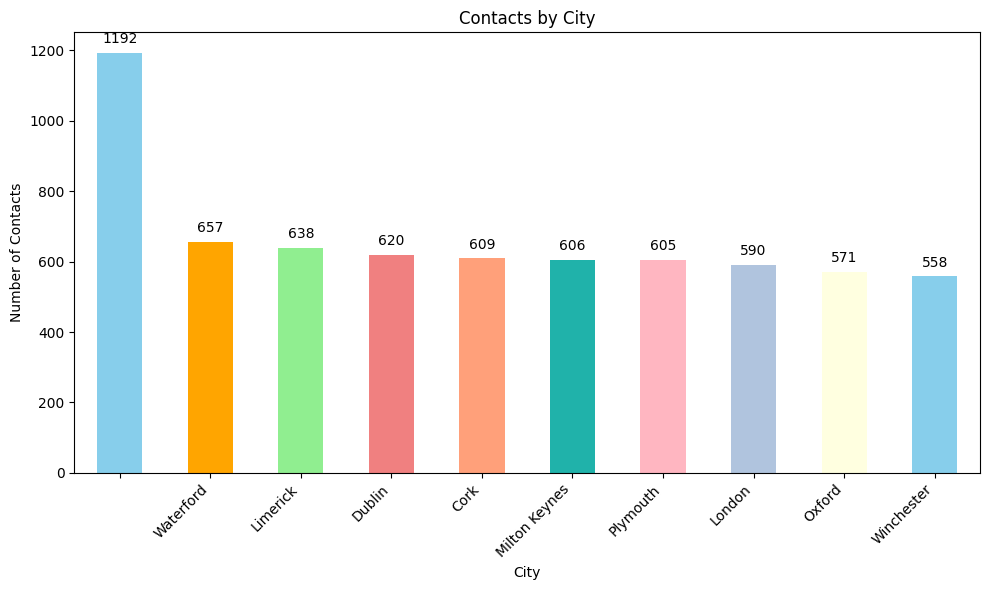

In [78]:
# Group the DataFrame by the 'city' column and count occurrences
city_counts = df_final['city'].value_counts()

# Create a bar chart with different colors for each bar and display the total on top of each bar
plt.figure(figsize=(10, 6))
ax = city_counts.plot(kind='bar', color=['skyblue', 'orange', 'lightgreen', 'lightcoral', 'lightsalmon', 'lightseagreen', 'lightpink', 'lightsteelblue', 'lightyellow'])
plt.title('Contacts by City')
plt.xlabel('City')
plt.ylabel('Number of Contacts')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Display the total value on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()

# Show the chart
plt.show()


C:\Users\sergi\AppData\Local\Temp\ipykernel_6780\1456174237.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['properties.technical_test___create_date'] = pd.to_datetime(df_country['properties.technical_test___create_date'])
C:\Users\sergi\AppData\Local\Temp\ipykernel_6780\1456174237.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country['properties.technical_test___create_date'] = pd.to_datetime(df_country['properties.technical_test___create_date'])


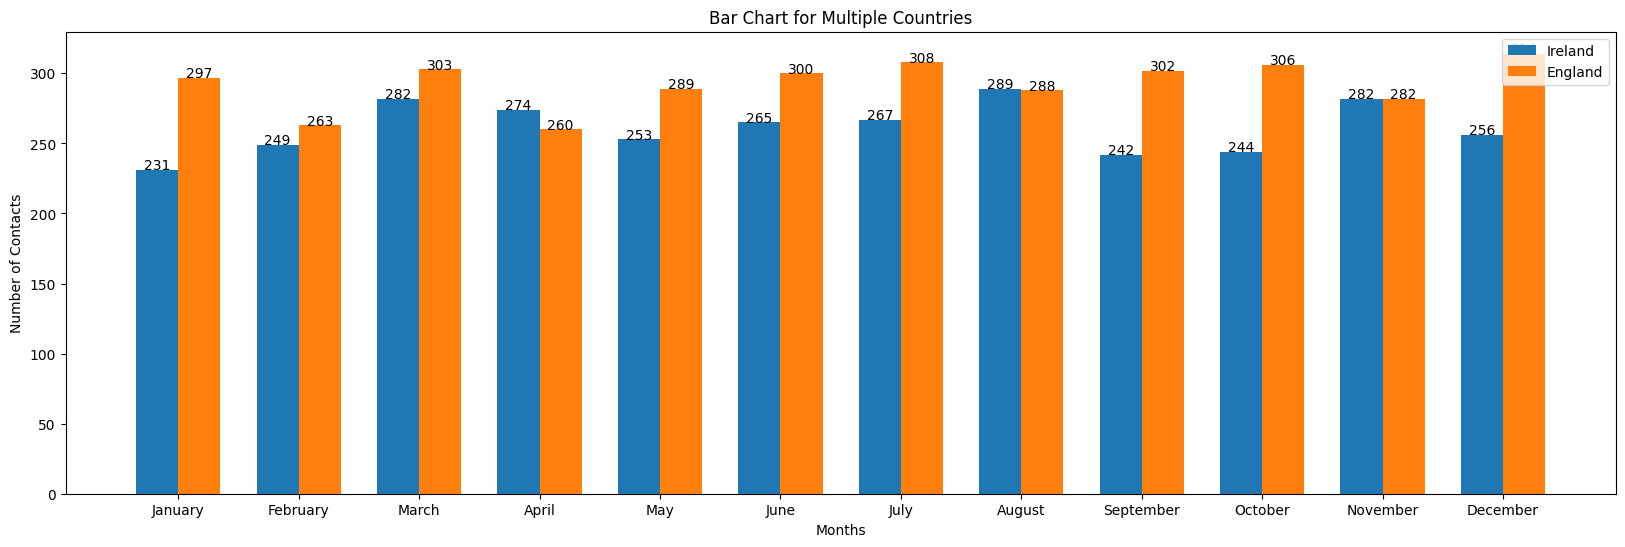

In [72]:


# Extract unique countries from the 'country' column in the DataFrame
countries = list(df_final['country'].unique())

# Process data for each country
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

data_dict = {}  # Dictionary to store processed data for each country
for country in countries:
    # Filter DataFrame for the current country
    df_country = df_final[df_final['country'] == country]
    
    # Convert the date column to datetime format
    df_country['properties.technical_test___create_date'] = pd.to_datetime(df_country['properties.technical_test___create_date'])
    
    # Group by month and count the number of occurrences
    date_groups = df_country.groupby(df_country['properties.technical_test___create_date'].dt.month).size()
    
    # Convert the grouped data to a list and store in the dictionary
    month_values = date_groups.values.tolist()
    data_dict[country] = month_values

# Bar chart configuration
bar_width = 0.35  # Width of the bars
x = np.arange(len(month))  # Positions for the bars on the x-axis

# Create the bar chart
plt.figure(figsize=(20, 6))
for country in countries:
    plt.bar(x + bar_width * (countries.index(country) - 0.5), data_dict[country], width=bar_width, label=country)

# Configure axes and labels
plt.xlabel('Months')
plt.ylabel('Number of Contacts')
plt.title('Bar Chart for Multiple Countries')
plt.xticks(x, month)
plt.legend()

# Display the total values on top of each bar
for i, country in enumerate(countries):
    for j, value in enumerate(data_dict[country]):
        plt.text(x[j] + bar_width * (i - 0.5), value + 0.1, str(value), ha='center')

# Display the chart
plt.show()


## Optional point


To maintain the "Street Address" records without losing any values, my proposal is to create a new property in HubSpot with the format of rich text. In this property, we will store the secondary "Street Address" records for the same contact. This will be done in a similar manner to how it was done with the "industry" property—concatenating all records and subsequently separating the main address from the other addresses. These secondary addresses will be stored in our new HubSpot property as rich text, allowing for organization in a way that distinguishes them within the property.

Example

The main address is stored in the property "address".

-Edwin   Rue, 3956


The other addresses are stored in our new secondary address property

-Besson  Avenue, 1005

-Sheraton   Hill, 1513


# Questions

## What is your usual IDE?

The IDE I use is Spider, but currently, I am exploring Visual Studio Code as a text editor.

## What are the advantages of this IDE over the others?
From my experience, Spider is commonly used for data science and data analysis. It provides tools for exploring and visualizing data effectively. Additionally, it features a user-friendly graphical interface.

## Which of the items resulted in the most computational time for you? Add time in seconds.

My saving_contacts function takes a total of 4560 seconds. Unlike other codes, it takes longer because it's creating one record at a time in HubSpot

## If you have any public portfolio (e.g., IA, computer visión, data processing...), please share the link with us.

Currently, I don't have a portfolio with projects, but I've worked on some in Google Colab and implemented various innovations with code at OnTheFuze. Additionally, I've undertaken tasks for clients.